<a href="https://colab.research.google.com/github/Arumat546/nico_cls/blob/main/%E3%83%8B%E3%82%B3%E3%83%8B%E3%82%B3%E3%82%AB%E3%83%86%E3%82%B4%E3%83%AA%E5%88%86%E9%A1%9EBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q gwpy
%cd /content/drive/My Drive/Google Colab/niconico_dataset_add_smid/

# 乱数シードの固定

import os
import random
import numpy as np
import torch

SEED_VALUE = 1234  # これはなんでも良い
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)  # PyTorchを使う場合


     |████████████████████████████████| 1.4MB 22.2MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 2.6MB 51.6MB/s 
/content/drive/My Drive/Google Colab/niconico_dataset_add_smid


## **データローダーの作成**

In [ ]:
#複数のtsvを同一データフレームに格納
import pandas as pd
import glob
 
path = "/content/drive/My Drive/Google Colab/niconico_dataset_add_smid/DATASET" # use your path
all_files = glob.glob(path + "/*.tsv")
 
list_dataset = []
 
for filename in all_files:
    df2 = pd.read_table(filename)
    list_dataset.append(df2)
 
df = pd.concat(list_dataset, axis=0, ignore_index=True)
print(df.loc[1000, :])

#データのシャッフル
df = df.sample(frac=1, random_state=121).reset_index(drop=True)
df.head()

# 分割してtsvファイルで保存する

# 全体の2割の文章数
len_0_2 = len(df) // 5

# 前から2割をテストデータとする
df[:len_0_2].to_csv("./test.tsv", sep='\t', index=False, header=None)
print(df[:len_0_2].shape)

# 前2割からあとを訓練&検証データとする
df[len_0_2:].to_csv("./train.tsv", sep='\t', index=False, header=None)
print(df[len_0_2:].shape)

content     普通に楽しいから来て♡名古屋民並感
category                    1
Name: 1000, dtype: object
(1199, 2)
(4799, 2)


## **ここから**

In [ ]:
# MeCabとtransformersの用意
%%capture
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.5
!pip install unidic-lite
!pip install transformers
!pip install fugashi
!pip install ipadic
import ipadic
import torch
import torchtext  # torchtextを使用
import torch.nn.functional as F
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer
from transformers import BertJapaneseTokenizer, BertForMaskedLM

# 日本語BERTの分かち書き用tokenizerです
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

In [ ]:
# データを読み込んだときに、読み込んだ内容に対して行う処理を定義

max_length = 512  # 東北大学_日本語版の最大の単語数（サブワード数）は512

def tokenizer_512(input_text):
    """torchtextのtokenizerとして扱えるように、512単語のpytorchでのencodeを定義。ここで[0]を指定し忘れないように"""
    return tokenizer.encode(input_text, max_length=512, return_tensors='pt')[0]

TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer_512, use_vocab=False, lower=False, include_lengths=True, batch_first=True, fix_length=max_length, pad_token=0)
# 注意：tokenize=tokenizer.encodeと、.encodeをつけます。padding[PAD]のindexが0なので、0を指定します。

LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

# (注釈)：各引数を再確認
# sequential: データの長さが可変か？文章は長さがいろいろなのでTrue.ラベルはFalse
# tokenize: 文章を読み込んだときに、前処理や単語分割をするための関数を定義
# use_vocab：単語をボキャブラリーに追加するかどうか
# lower：アルファベットがあったときに小文字に変換するかどうか
# include_length: 文章の単語数のデータを保持するか
# batch_first：ミニバッチの次元を用意するかどうか
# fix_length：全部の文章をfix_lengthと同じ長さになるように、paddingします
# init_token, eos_token, pad_token, unk_token：文頭、文末、padding、未知語に対して、どんな単語を与えるかを指定


In [ ]:
%%capture
#@title デフォルトのタイトル テキスト
# 各tsvファイルを読み込み、分かち書きをしてdatasetにします
# 少し時間がかかります
# train_eval：個、test：個
dataset_train_eval, dataset_test = torchtext.data.TabularDataset.splits(path='.', train='train.tsv', test='test.tsv', format='tsv', fields=[('content', TEXT), ('category', LABEL)])

In [ ]:
# torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
import random

dataset_train, dataset_eval = dataset_train_eval.split(split_ratio=1.0 - 1/4, random_state=random.seed(1234))

# datasetの長さを確認してみる
print(dataset_train.__len__())
print(dataset_eval.__len__())
print(dataset_test.__len__())

3599
1200
1199


In [ ]:
# datasetの中身を確認してみる
item = next(iter(dataset_train))
print(item.content)
print("長さ：", len(item.content))  # 長さを確認 [CLS]から始まり[SEP]で終わる。512より長いと後ろが切れる
print("ラベル：", item.category)

# datasetの中身を文章に戻し、確認
print(tokenizer.convert_ids_to_tokens(item.content.tolist()))  # 文章
#dic_id2cat[int(item.category)]  # id

tensor([    2,   220, 28582, 28478,    40,  3635,     3])
長さ： 7
ラベル： 0
['[CLS]', 'ハ', '##ズ', '##イ', 'から', 'だろ', '[SEP]']


In [ ]:
# DataLoaderを作成します（torchtextの文脈では単純にiteraterと呼ばれています）
batch_size = 16  # BERTでは16、32あたりを使用する####################################################################

dl_train = torchtext.data.Iterator(
    dataset_train, batch_size=batch_size, train=True)

dl_eval = torchtext.data.Iterator(
    dataset_eval, batch_size=batch_size, train=False, sort=False)

dl_test = torchtext.data.Iterator(
    dataset_test, batch_size=batch_size, train=False, sort=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": dl_train, "val": dl_eval}

# DataLoaderの動作確認 

batch = next(iter(dl_test))
print(batch)
print(batch.content[0].shape)
print(batch.category.shape)


[torchtext.data.batch.Batch of size 16]
	[.content]:('[torch.LongTensor of size 16x512]', '[torch.LongTensor of size 16]')
	[.category]:[torch.LongTensor of size 16]
torch.Size([16, 512])
torch.Size([16])


## **BERTのクラス分類用のモデルを用意する**

In [ ]:
from transformers.modeling_bert import BertModel
from torch import nn

# BERTの日本語学習済みパラメータのモデル
model = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
#print(model)

class BertForNico(nn.Module):
    '''BERTモデルに3クラスを判定する部分をつなげたモデル'''

    def __init__(self):
        super(BertForNico, self).__init__()

        # BERTモジュール
        self.bert = model  # 日本語学習済みのBERTモデル

        # headにクラス予測を追加
        # 入力はBERTの出力特徴量の次元768、出力は3クラス
        self.cls = nn.Linear(in_features=768, out_features=3)###############################################################################################クラス数注意！！！！！！！！！！！！！！！

        # 重み初期化処理
        nn.init.normal_(self.cls.weight, std=0.02)
        nn.init.normal_(self.cls.bias, 0)

    def forward(self, input_ids):
        '''
        input_ids： [batch_size, sequence_length]の文章の単語IDの羅列
        '''

        # BERTの基本モデル部分の順伝搬
        # 順伝搬させる
        result = self.bert(input_ids)  # reult は、sequence_output, pooled_output

        # sequence_outputの先頭の単語ベクトルを抜き出す
        vec_0 = result[0]  # 最初の0がsequence_outputを示す
        vec_0 = vec_0[:, 0, :]  # 全バッチ。先頭0番目の単語の全768要素
        vec_0 = vec_0.view(-1, 768)  # sizeを[batch_size, hidden_size]に変換
        output = self.cls(vec_0)  # 全結合層

        return output

In [ ]:
# モデル構築
net = BertForNico()

# 訓練モードに設定
net.train()

print('ネットワーク設定完了')

ネットワーク設定完了


## **ファインチューニングの設定**

In [ ]:
# 勾配計算を最後のBertLayerモジュールと追加した分類アダプターのみ実行

# 1. まず全部を、勾配計算Falseにしてしまう
for param in net.parameters():
    param.requires_grad = False

# 2. BertLayerモジュールの最後を勾配計算ありに変更
for param in net.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

# 3. 識別器を勾配計算ありに変更
for param in net.cls.parameters():
    param.requires_grad = True

# 最適化手法の設定
import torch.optim as optim

# BERTの元の部分はファインチューニング
optimizer = optim.Adam([
    {'params': net.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
    {'params': net.cls.parameters(), 'lr': 1e-4}
])

# 損失関数の設定
criterion = nn.CrossEntropyLoss()
# nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

## **学習の実施**

# 従来手法

In [ ]:
# モデルを学習させる関数を作成

#正解率記録用リスト
EpAc_train = []
EpAc_val = []

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # ミニバッチのサイズ
    batch_size = dataloaders_dict["train"].batch_size

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数
            iteration = 1

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書型変数

                # GPUが使えるならGPUにデータを送る
                inputs = batch.content[0].to(device)  # 文章
                labels = batch.category.to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # BERTに入力
                    outputs = net(inputs) #outputs=[32行(バッチ数)、2列（クラス分類結果）]

                    loss = criterion(outputs, labels)  # 損失を計算

                    _, preds = torch.max(outputs, 1)  # ラベルを予測  32データ分の数値が大きい方のクラスを一次元配列で返すメソッド

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            acc = (torch.sum(preds == labels.data)
                                   ).double()/batch_size
                            print('イテレーション {} || Loss: {:.4f} || 10iter. || 本イテレーションの正解率：{}'.format(
                                iteration, loss.item(),  acc))

                    iteration += 1

                    # 損失と正解数の合計を更新
                    epoch_loss += loss.item() * batch_size
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            #正解率をリストに格納
            if phase == 'train':
              EpAc_train.append(epoch_acc)
            
            else :
              EpAc_val.append(epoch_acc)

            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))

    
    return net

## **提案手法**

In [ ]:
# 棄却有りのとき

#正解率記録用リスト
EpAc_train = []
EpAc_val = []

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')

    # ネットワークをGPUへ
    savemodel=net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # ミニバッチのサイズ
    batch_size = dataloaders_dict["train"].batch_size

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数
            iteration = 1

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書型変数

                # GPUが使えるならGPUにデータを送る
                inputs = batch.content[0].to(device)  # 文章
                labels = batch.category.to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # BERTに入力
                    outputs = net(inputs)
   
                    # 損失を計算(DG考慮)
                    if epoch >= pretrain:
                      outputs = F.softmax(outputs,dim=1)

                      outputs, reservation = outputs[:,:-1], outputs[:,-1] #[全行、最後以外全列],[全行、最後の列]

                    #unsqeeze(1)でonehotベクトル化
                    #labelsの要素が1のとこと同じ要素をoutputsから取り出す
                      gain = torch.gather(outputs,dim=1,index=labels.unsqueeze(1)).squeeze() 

                      doubling_rate = (gain.add(reservation.div(reward))).log()
           
                      loss = -doubling_rate.mean()

                    else:
                      loss = criterion(outputs[:,:-1],labels)

                    _, preds = torch.max(outputs, 1)  # ラベルを予測　_は出力の最大値、predsは出力の最大位置（クラス）

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            acc = (torch.sum(preds == labels.data)
                                   ).double()/batch_size
                            print('イテレーション {} || Loss: {:.4f} || 10iter. || 本イテレーションの正解率：{}'.format(
                                iteration, loss.item(),  acc))

                    iteration += 1

                    # 損失と正解数の合計を更新
                    epoch_loss += loss.item() * batch_size
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            #正解率をリストに格納
            if phase == 'train':
              EpAc_train.append(epoch_acc)
            
            else :
              EpAc_val.append(epoch_acc)

            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))

    
    return net

In [ ]:
# 学習・検証
num_epochs = 9
pretrain = 3
reward =  1.9  #棄却度を決めるハイパーパラメータ

net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)

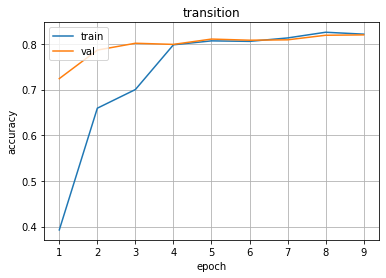

In [ ]:
#グラフを描画
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

epoch = ["1", "2", "3","4","5","6","7","8","9"]
#EpAc_train = [0.60, 0.65, 0.66, 0.70, 0.68]
#EpAc_val = [0.63, 0.67, 0.68, 0.72, 0.68]

plt.title("transition")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(epoch, EpAc_train, label = "train")
plt.plot(epoch, EpAc_val, label = "val")
plt.legend(loc = "upper left")
plt.grid(True)
plt.show()


## **テスト**

In [ ]:
#自作テストデータで検証する場合
%%capture
dataset_train_eval, dataset_test = torchtext.data.TabularDataset.splits(path='.', train='train.tsv', test='testtt.tsv', format='tsv', fields=[('content', TEXT), ('category', LABEL)])
dl_test = torchtext.data.Iterator(dataset_test, batch_size=batch_size, train=False, sort=False)
batch = next(iter(dl_test))

In [ ]:
#通常のテスト
from tqdm import tqdm
import numpy as np

preds_all = np.array([],dtype=int)

# テストデータでの正解率を求める
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained.eval()   # モデルを検証モードに
net_trained.to(device)  # GPUが使えるならGPUへ送る

# epochの正解数を記録する変数
epoch_corrects = 0

for batch in tqdm(dl_test):  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    # GPUが使えるならGPUにデータを送る
    inputs = batch.content[0].to(device)  # 文章
    labels = batch.category.to(device)  # ラベル

    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):

        # BertForNicoに入力
        outputs = net_trained(inputs)

        loss = criterion(outputs, labels)  # 損失を計算
        _, preds = torch.max(outputs, 1)  # ラベルを予測
        preds_all = np.append(preds_all, preds.cpu().numpy())
       

        epoch_corrects += torch.sum(preds == labels.data)  # 正解数の合計を更新

# 正解率
epoch_acc = epoch_corrects.double() / len(dl_test.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), epoch_acc))
print(preds_all)

100%|██████████| 75/75 [00:42<00:00,  1.75it/s]

テストデータ1199個での正解率：0.8232
[1 1 0 ... 0 1 1]


In [ ]:
#提案手法

from tqdm import tqdm
import numpy as np

expected_coverage = [90,80,70,60]
text_data=[]
abstention_results = []
preds_all = np.array([],dtype=int)

# テストデータでの正解率を求める
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained.eval()   # モデルを検証モードに
net_trained.to(device)  # GPUが使えるならGPUへ送る

# epochの正解数を記録する変数
epoch_corrects = 0

for batch in tqdm(dl_test):  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    # GPUが使えるならGPUにデータを送る
    inputs = batch.content[0].to(device)  # 文章
    labels = batch.category.to(device)  # ラベル
    #print(batch.content[0])

    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):
        # BertForNicoに入力
      outputs = net_trained(inputs)
      values, predictions = torch.max(outputs, 1) 
      


    #損失計算
      outputs = F.softmax(outputs,dim=1)
      outputs, reservation = outputs[:,:-1], outputs[:,-1] #[全行、最後以外全列],[全行、最後の列]

      #abstention_results.extend(zip(list(reservation.cpu().numpy()),list(predictions.eq(labels.data).cpu().numpy(),list(inputs.data.cpu().numpy()))))
      abstention_results.extend(zip(list(reservation.cpu().numpy()),list(predictions.eq(labels.data).cpu().numpy()),list(inputs.data.cpu().numpy())))
      gain = torch.gather(outputs,dim=1,index=labels.unsqueeze(1)).squeeze()
      doubling_rate = (gain.add(reservation.div(reward))).log()

      loss = -doubling_rate.mean()
      preds_all = np.append(preds_all, predictions.cpu().numpy())
      epoch_corrects += torch.sum(predictions == labels.data)  # 正解数の合計を更新
        

#棄却判定後の計算
#棄権の結果を予約の高低に応じて並べ替える(降順)
abstention_results.sort(key = lambda x: x[0], reverse=True)#リストの1列目の要素をキーに並び替える

# ソートされた結果の「正しいかどうか」のリストを取得する
#map(関数、加工元)…加工元データに関数をかけたものをリスト取得する
sorted_correct = list(map(lambda x: int(x[1]), abstention_results))

#テキストリストを取得
for i in range(len(dl_test.dataset)):
  text_data.append(abstention_results[i][2])

#棄却されたテキストの表示

#print("4")
#print(abstention_results)
print("sorted_correct")
print(sorted_correct)

size = len(dl_test.dataset)

print('accracy of coverage ',end='')
for coverage in expected_coverage:
  #print('{:.0f}: {:.3f}, '.format(coverage, sum(sorted_correct[int(size*coverage/100):])),end='')
  print(coverage)
  count1=int(size*(100-coverage)/100) 
  count2=sum(sorted_correct[count1:])
  count3=size-count1 #カバレッジ考慮のデータ数
  acc_cov=count2/count3
  print(acc_cov)
  if coverage==70:
    for j in range(count1):  
      print(tokenizer.convert_ids_to_tokens(text_data[j]))

# 正解率
epoch_acc = epoch_corrects.double() / len(dl_test.dataset)
print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), epoch_acc))

#print(preds_all)

## **推論結果の出力**

In [ ]:
#推論結果の出力
%cd /content/drive/My Drive/Google Colab/niconico_dataset_add_smid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

df = pd.Cov = pd.read_csv("test.tsv", sep='\t',names=["content", "category", "predict"])
net_trained.eval()  #推論モードに

for index, row in df.iterrows():
    df.at[index, "predict"] = preds_all[index]  # GPU環境の場合は「.cpu().numpy()」としてください。

df.to_csv("predicted_test.tsv", sep='\t', index=False)

/content/drive/My Drive/Google Colab/niconico_dataset_add_smid


In [ ]:
#混合行列の表示（評価）

y_true =[]
y_pred =[]
df = pd.read_csv("predicted_test.tsv",  sep='\t',engine="python", encoding="utf-8")
for index, row in df.iterrows():
    if row['category'] == 0:
        y_true.append("0")
    if row['category'] ==1:
        y_true.append("1")
    if row['predict'] ==0:
        y_pred.append("0")
    if row['predict'] ==1:
        y_pred.append("1")


print(len(y_true))
print(len(y_pred))


# 混同行列(confusion matrix)の取得
labels = ["0", "1"]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# データフレームに変換
cm_labeled = pd.DataFrame(cm, columns=labels, index=labels)

# 結果の表示
cm_labeled

395
509


ValueError: ignored

In [ ]:
#各種推論計算結果の表示
y_true =[]
y_pred =[]
df = pd.read_csv("predicted_test.tsv", sep='\t', engine="python", encoding="utf-8")
for index, row in df.iterrows():
    y_true.append(row["category"])
    y_pred.append(row["predict"])

print("正解率（すべてのサンプルのうち正解したサンプルの割合）={}%".format((round(accuracy_score(y_true, y_pred),2)) *100 ))
print("適合率（positiveと予測された中で実際にpositiveだった確率）={}%".format((round(precision_score(y_true, y_pred),2)) *100 ))
print("再現率（positiveなデータに対してpositiveと予測された確率）={}%".format((round(recall_score(y_true, y_pred),2)) *100 ))
print("F1（適合率と再現率の調和平均）={}%".format((round(f1_score(y_true, y_pred),2)) *100 ))

正解率（すべてのサンプルのうち正解したサンプルの割合）=82.0%
適合率（positiveと予測された中で実際にpositiveだった確率）=74.0%
再現率（positiveなデータに対してpositiveと予測された確率）=97.0%
F1（適合率と再現率の調和平均）=84.0%


## **ハイパーパラメータチューニング**

In [ ]:
#訓練＆検証
!pip install optuna
import optuna
import torch
import torch.optim as optim

num_epochs = 9
pretrain = 3
reward =  1.9  #棄却度を決めるハイパーパラメータ

#net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)

def objective(trial):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = net.to(device)

    #criterion = nn.CrossEntropyLoss()
    
    # Training
    for step in range(num_epochs):
        train(model, device, train_loader, optimizer, criterion)
        
    # Evaluation
    accuracy = evaluate(model, device, test_loader)
  
    # 返り値が最小となるようにハイパーパラメータチューニングが実行される
    return 1.0 - accuracyoptimizer)(net.parameters(), lr=learning_rate)


In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=50)

In [ ]:
# 一番良い結果
study.best_trial
 
'''
{'hidden_dim': 72,
 'learning_rate': 0.09883,
 'n_layers': 4,
 'optimizer': 'Adam'}
'''
 
# データフレームで確認
study.trials_dataframe()
 
# values が objective 関数の返り値
study.trials_dataframe().sort_values("value").head(10)

## **その他**

In [ ]:
#モデルの保存
torch.save(train_model.state_dict(), "model.pth")

NameError: ignored

In [ ]:
#モデルの読み込み
param=torch.load('model.pth')
model=Net()
model.load_state_dict(param)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       